In [5]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import username, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

#### Wrangle

In [13]:
def get_saas():
    
    if os.path.isfile('saas.csv'):
        df = pd.read_csv('saas.csv')
    return df

In [14]:
df = get_saas()

In [15]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [19]:
df['Month_Invoiced'] = pd.to_datetime(df['Month_Invoiced'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Month_Invoiced     790458 non-null  datetime64[ns]
 1   Customer_Id        790458 non-null  int64         
 2   Invoice_Id         790458 non-null  int64         
 3   Subscription_Type  790458 non-null  float64       
 4   Amount             790458 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 30.2 MB


In [21]:
df = df.set_index('Month_Invoiced').sort_index()

In [22]:
df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [23]:
df.Subscription_Type.value_counts()

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: Subscription_Type, dtype: int64

In [24]:
df.Customer_Id.nunique()

29400

In [26]:
df.Invoice_Id.nunique()

790458

In [25]:
len(df)

790458

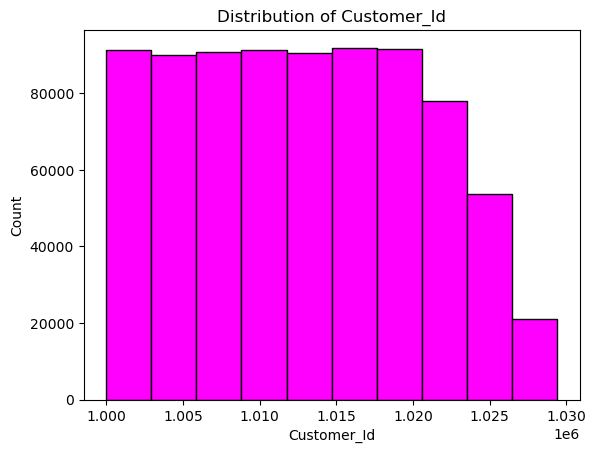

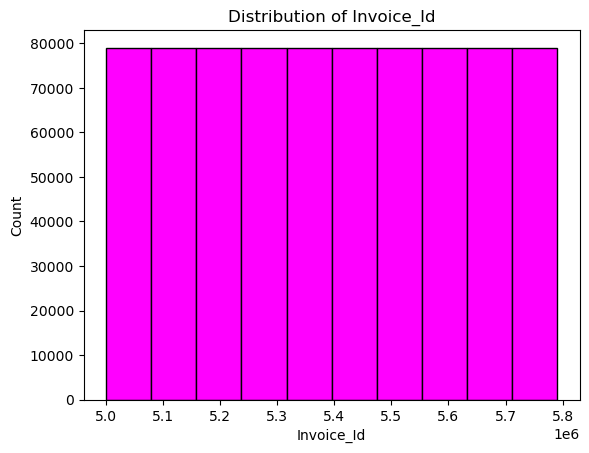

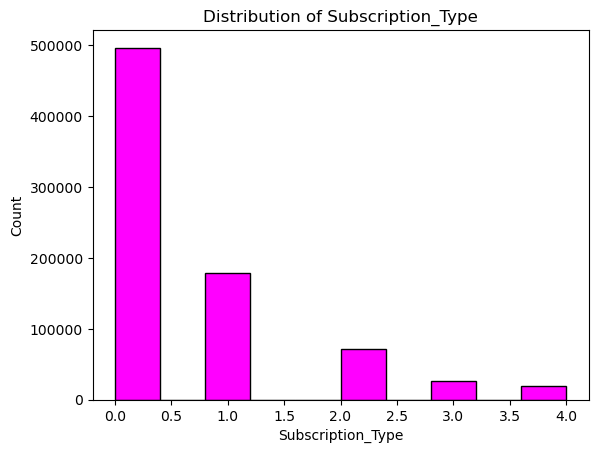

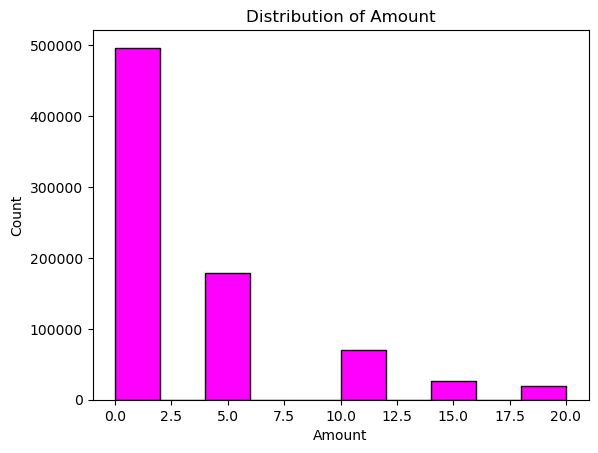

In [30]:
for col in df.columns:
    plt.hist(df[col], color='magenta', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Count')
    plt.show()

In [32]:
by_date = df.groupby('Month_Invoiced').Amount.sum().reset_index()

<AxesSubplot:xlabel='Month_Invoiced'>

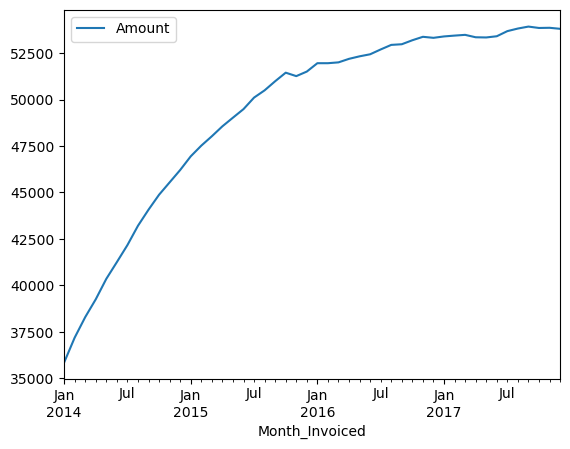

In [33]:
by_date.plot(x='Month_Invoiced', y='Amount')

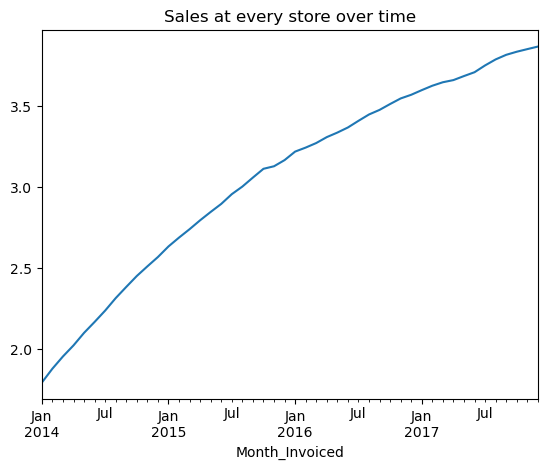

In [35]:
df.groupby('Month_Invoiced').Amount.mean().plot()
plt.title('Sales over time')
plt.show()

In [36]:
df_month = df.resample('M')[['Amount']].sum()

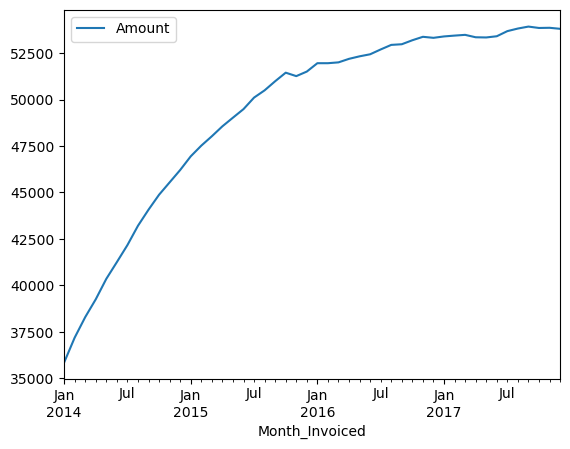

In [51]:
df_month.plot()
plt.show()

In [38]:
df_year = df.resample('Y')[['Amount']].sum()

In [49]:
df_year

,Amount
Month_Invoiced,
2014-12-31,498290.0
2015-12-31,595355.0
2016-12-31,631355.0
2017-12-31,643350.0


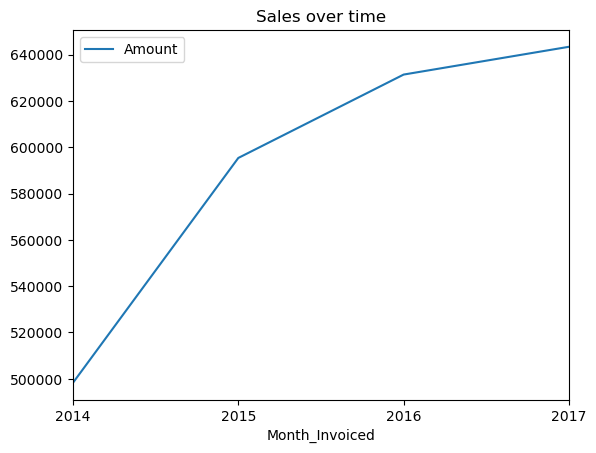

In [47]:
df_year.plot()
plt.title('Sales over time')
plt.show()

##### Split Data

In [52]:
train_size = .7

In [53]:
train_index = round(train_size * df.shape[0])

In [54]:
train_index

553321

In [55]:
train = df.reset_index()[:train_index]
test = df.reset_index()[train_index:]

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553321 entries, 0 to 553320
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Month_Invoiced     553321 non-null  datetime64[ns]
 1   Customer_Id        553321 non-null  int64         
 2   Invoice_Id         553321 non-null  int64         
 3   Subscription_Type  553321 non-null  float64       
 4   Amount             553321 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 21.1 MB


In [57]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237137 entries, 553321 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Month_Invoiced     237137 non-null  datetime64[ns]
 1   Customer_Id        237137 non-null  int64         
 2   Invoice_Id         237137 non-null  int64         
 3   Subscription_Type  237137 non-null  float64       
 4   Amount             237137 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 9.0 MB


In [64]:
train.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [68]:
train = train.set_index('Month_Invoiced').sort_index()

KeyError: "None of ['Month_Invoiced'] are in the columns"

In [67]:
test = test.set_index('Month_Invoiced').sort_index()

<AxesSubplot:xlabel='Month_Invoiced'>

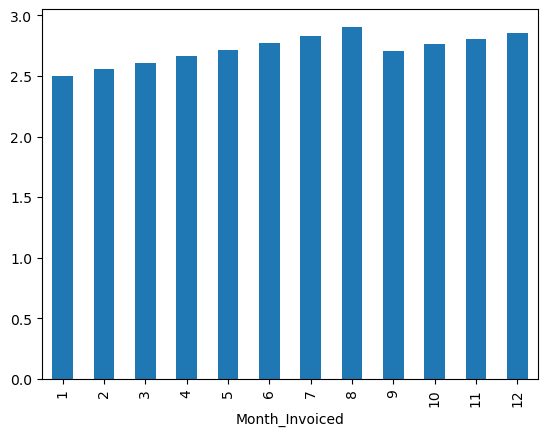

In [70]:
train.groupby(train.index.month).Amount.mean().plot.bar()

<AxesSubplot:xlabel='Month_Invoiced'>

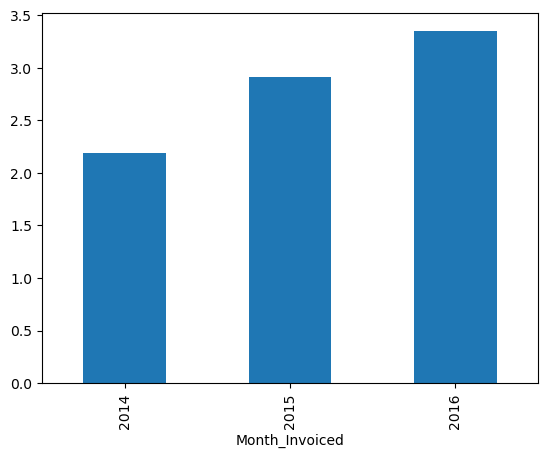

In [71]:
train.groupby(train.index.year).Amount.mean().plot.bar()

In [77]:
print(f'df length: {len(df)}')
print(f'Unique days: {df.index.nunique()}')

df length: 790458
Unique days: 48


In [128]:
df_resampled = df.resample('M')[['Amount']].sum()
df_resampled

,Amount
Month_Invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


In [129]:
train_size = int(len(df_resampled) * .5)
validate_size = int(len(df_resampled) * .3)
test_size = int(len(df_resampled) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df_resampled[: train_size]
validate = df_resampled[train_size : validate_end_index]
test = df_resampled[validate_end_index : ]

In [130]:
train.shape, validate. shape, test.shape

((24, 1), (14, 1), (10, 1))

In [131]:
y = train.Amount

In [132]:
train['weekday'] = train.index.day_name()

<AxesSubplot:xlabel='weekday'>

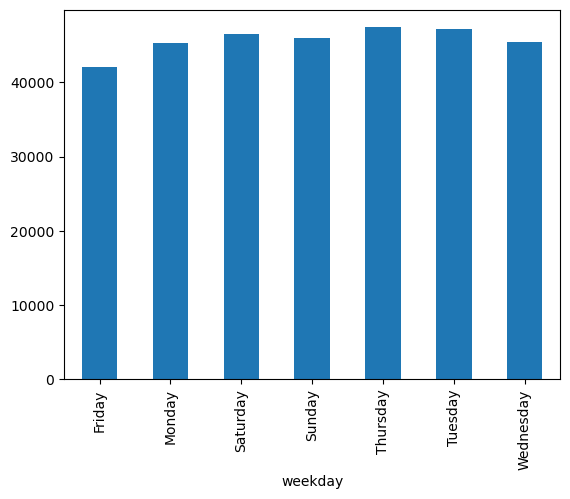

In [133]:
train.groupby('weekday').Amount.mean().plot.bar()

<AxesSubplot:xlabel='weekday', ylabel='Amount'>

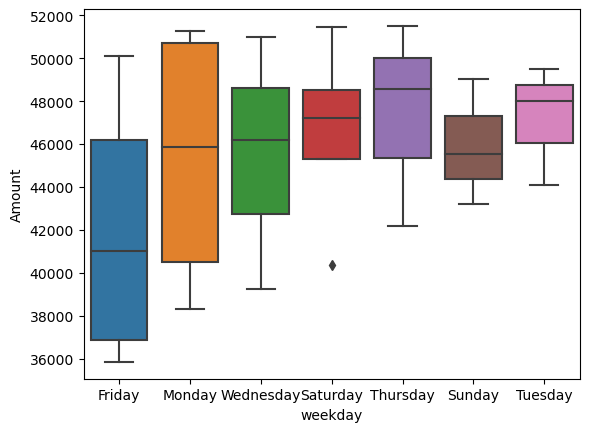

In [134]:
sns.boxplot(data=train, x='weekday', y='Amount')

<AxesSubplot:xlabel='Month_Invoiced'>

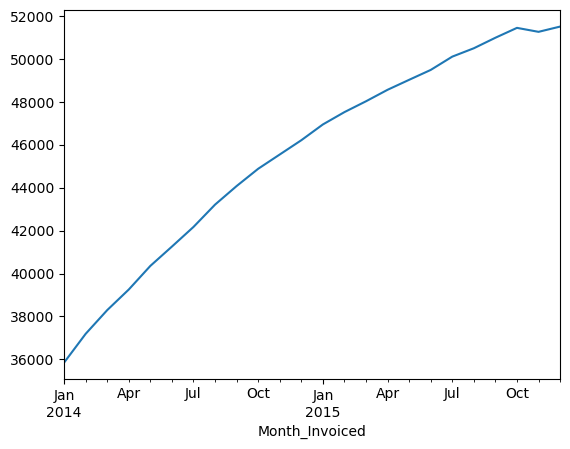

In [135]:
y.plot()

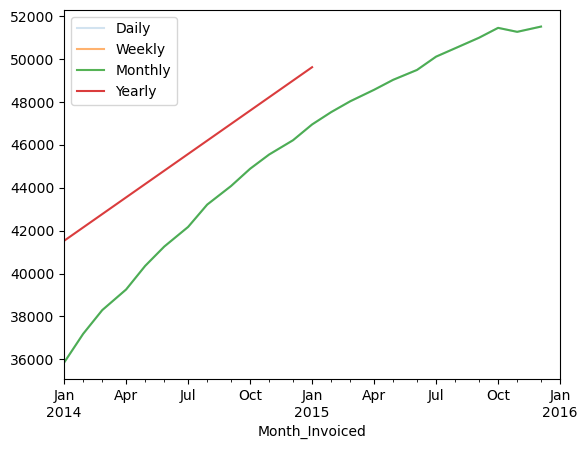

In [136]:
y.plot(alpha=0.2, label='Daily')
y.resample('W').mean().plot(alpha=0.6, label='Weekly')
y.resample('M').mean().plot(alpha=0.8, label='Monthly')
y.resample('Y').mean().plot(alpha=0.9, label='Yearly')
plt.legend()
plt.show()

In [137]:
pd.concat([y.resample('M').mean(), 
           y.resample('M').mean().diff()], axis=1).head()

,Amount,Amount
Month_Invoiced,,
2014-01-31,35850.0,NaN
2014-02-28,37190.0,1340.0
2014-03-31,38295.0,1105.0
2014-04-30,39255.0,960.0
2014-05-31,40355.0,1100.0


#### Forecasting

In [ ]:
# Last Observed Value

In [138]:
train['Amount'][-1:][0]

51505.0

In [144]:
train['yhat'] = (train['Amount'][-1:][0])
validate['yhat'] = (train['Amount'][-1:][0])

In [140]:
train.head()

,Amount,weekday,yhat
Month_Invoiced,,,
2014-01-31,35850.0,Friday,51505.0
2014-02-28,37190.0,Friday,51505.0
2014-03-31,38295.0,Monday,51505.0
2014-04-30,39255.0,Wednesday,51505.0
2014-05-31,40355.0,Saturday,51505.0


In [142]:
import evaluate as e

In [157]:
rmse = round(sqrt(mean_squared_error(validate['Amount'], validate['yhat'])), 0)
rmse

1343.0

In [158]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
d = {'model_type': 'last_observed_value', 'target_var': 'Amount', 'rmse': [rmse]}
d = pd.DataFrame(d)
eval_df.append(d, ignore_index = True)

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0


In [ ]:
# Simple Average

In [148]:
avg_amount = round(train['Amount'].mean(), 2)
avg_amount

45568.54

In [149]:
validate['avg_amount'] = avg_amount

In [161]:
rmse = round(sqrt(mean_squared_error(validate['Amount'], validate['avg_amount'])), 0)
d = {'model_type': 'simple_average', 'target_var': 'Amount', 'rmse': [rmse]}
d = pd.DataFrame(d)
eval_df.append(d, ignore_index = True)

,model_type,target_var,rmse
0,simple_average,Amount,7181.0


In [162]:
# Rolling Average

In [165]:
period = 1

rolling_amount = round(train['Amount'].rolling(period).mean()[-1], 2)

validate['rolling_avg'] = rolling_amount

validate.head()

,Amount,yhat,avg_amount,rolling_avg
Month_Invoiced,,,,
2016-01-31,51955.0,51505.0,45568.54,51505.0
2016-02-29,51955.0,51505.0,45568.54,51505.0
2016-03-31,52000.0,51505.0,45568.54,51505.0
2016-04-30,52190.0,51505.0,45568.54,51505.0
2016-05-31,52325.0,51505.0,45568.54,51505.0
2016-06-30,52435.0,51505.0,45568.54,51505.0
2016-07-31,52695.0,51505.0,45568.54,51505.0
2016-08-31,52940.0,51505.0,45568.54,51505.0
2016-09-30,52975.0,51505.0,45568.54,51505.0


In [167]:
rmse = round(sqrt(mean_squared_error(validate['Amount'], validate['rolling_avg'])), 0)
d = {'model_type': 'rolling_average', 'target_var': 'Amount', 'rmse': [rmse]}
d = pd.DataFrame(d)
eval_df.append(d, ignore_index = True)

,model_type,target_var,rmse
0,rolling_average,Amount,1343.0


In [171]:
# periods = [62, 93, 124]

# for p in periods: 
#     rolling_amounts = round(train['Amount'].rolling(p).mean()[-1], 2)
#     model_type = str(p) + '_day_moving_avg'
#     validate[model_type] = rolling_amounts
#     rmse = round(sqrt(mean_squared_error(validate['Amount'], validate[model_type])), 0)
#     d = {'model_type': [model_type], 'target_var': 'Amount', 'rmse': [rmse]}
#     d = pd.DataFrame(d)
#     eval_df.append(d, ignore_index = True)


In [ ]:
# Holt's Linear Trend

In [172]:
model = Holt(train['Amount'], exponential=False, damped=False)

In [173]:
model = model.fit(optimized=True)

In [174]:
validate['holts_yhat'] = model.predict(start=validate.index[0],
                                      end=validate.index[-1])

In [175]:
validate

,Amount,yhat,avg_amount,rolling_avg,60_day_moving_avg,61_day_moving_avg,62_day_moving_avg,holts_yhat
Month_Invoiced,,,,,,,,
2016-01-31,51955.0,51505.0,45568.54,51505.0,NaN,NaN,NaN,51915.139274
2016-02-29,51955.0,51505.0,45568.54,51505.0,NaN,NaN,NaN,52186.276655
2016-03-31,52000.0,51505.0,45568.54,51505.0,NaN,NaN,NaN,52457.414037
2016-04-30,52190.0,51505.0,45568.54,51505.0,NaN,NaN,NaN,52728.551418
2016-05-31,52325.0,51505.0,45568.54,51505.0,NaN,NaN,NaN,52999.688800
2016-06-30,52435.0,51505.0,45568.54,51505.0,NaN,NaN,NaN,53270.826181
2016-07-31,52695.0,51505.0,45568.54,51505.0,NaN,NaN,NaN,53541.963563
2016-08-31,52940.0,51505.0,45568.54,51505.0,NaN,NaN,NaN,53813.100944
2016-09-30,52975.0,51505.0,45568.54,51505.0,NaN,NaN,NaN,54084.238326


In [176]:
rmse = round(sqrt(mean_squared_error(validate['Amount'], validate['holts_yhat'])), 0)
d = {'model_type': 'holts_linear_trend', 'target_var': 'Amount', 'rmse': [rmse]}
d = pd.DataFrame(d)
eval_df.append(d, ignore_index = True)

,model_type,target_var,rmse
0,holts_linear_trend,Amount,1101.0
